In [10]:
import sys
sys.path.insert(0, '..')

import torch
import os
import wandb
import random
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from tqdm import tqdm
from matplotlib import cm
import seaborn as sns
from PIL import Image
import umap
import torch.nn.functional as F
import math
from scipy.stats import norm
import joblib
from sklearn.metrics import confusion_matrix

from core.final.dataset import PSMDataset
from core.final.model import GalSpecNet, MetaModel, Informer, AstroModel
from core.final.trainer import Trainer

In [3]:
random_seed = 42
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
def get_embs(dataloader):
    all_p_emb, all_s_emb, all_m_emb = [], [], []
    all_labels = []
    
    for photometry, photometry_mask, spectra, metadata, labels in tqdm(dataloader):
        photometry, photometry_mask = photometry.to(device), photometry_mask.to(device)
        spectra, metadata = spectra.to(device), metadata.to(device)
    
        with torch.no_grad():
            p_emb, s_emb, m_emb = model.get_embeddings(photometry, photometry_mask, spectra, metadata)
    
            all_p_emb.append(p_emb.cpu())
            all_s_emb.append(s_emb.cpu())
            all_m_emb.append(m_emb.cpu())
            all_labels.append(labels)
    
    all_p_emb = torch.vstack(all_p_emb)
    all_s_emb = torch.vstack(all_s_emb)
    all_m_emb = torch.vstack(all_m_emb)
    all_labels = torch.hstack(all_labels)

    return all_p_emb, all_s_emb, all_m_emb, all_labels

In [34]:
run_id = 'MeriDK/AstroCLIPResults3/dw71clqy'
api = wandb.Api()
run = api.run(run_id)
config = run.config
config['use_wandb'] = False

model = AstroModel(config)
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()

weights_path = os.path.join(config['weights_path'] + '-' + run_id.split('/')[-1], f'weights-best.pth')
model.load_state_dict(torch.load(weights_path, weights_only=False))

<All keys matched successfully>

In [35]:
train_dataset = PSMDataset(config, split='train')
train_dataloader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=False)

val_dataset = PSMDataset(config, split='val')
val_dataloader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)

test_dataset = PSMDataset(config, split='test')
test_dataloader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)

In [36]:
train_p_emb, train_s_emb, train_m_emb, train_labels = get_embs(train_dataloader)
val_p_emb, val_s_emb, val_m_emb, val_labels = get_embs(val_dataloader)
test_p_emb, test_s_emb, test_m_emb, test_labels = get_embs(test_dataloader)

100%|██████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:16<00:00,  5.62s/it]


In [37]:
test_emb = (test_p_emb + test_s_emb + test_m_emb) / 3
test_logits = model.fc(test_emb.to(device))
probabilities = torch.nn.functional.softmax(test_logits, dim=1)
_, predicted_labels = torch.max(probabilities, dim=1)

In [38]:
p_logits = model.fc(test_p_emb.to(device))
p_prob = torch.nn.functional.softmax(p_logits, dim=1)
_, p_pred = torch.max(p_prob, dim=1)

In [39]:
s_logits = model.fc(test_s_emb.to(device))
s_prob = torch.nn.functional.softmax(s_logits, dim=1)
_, s_pred = torch.max(s_prob, dim=1)

In [40]:
m_logits = model.fc(test_m_emb.to(device))
m_prob = torch.nn.functional.softmax(m_logits, dim=1)
_, m_pred = torch.max(m_prob, dim=1)

In [41]:
avg = confusion_matrix(test_labels, predicted_labels.cpu())
p = confusion_matrix(test_labels, p_pred.cpu())
s = confusion_matrix(test_labels, s_pred.cpu())
m = confusion_matrix(test_labels, m_pred.cpu())

In [42]:
avg_percent = 100 * avg / avg.sum(axis=1)[:, np.newaxis]
p_percent = 100 * p / p.sum(axis=1)[:, np.newaxis]
s_percent = 100 * s / s.sum(axis=1)[:, np.newaxis]
m_percent = 100 * m / m.sum(axis=1)[:, np.newaxis]

In [43]:
def plot_matrices(matrix, matrix_percent):
    labels = [test_dataset.id2target[i] for i in range(len(avg_percent))]
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))
    
    # Plot absolute values confusion matrix
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=axes[0])
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('True')
    axes[0].set_title('Confusion Matrix - Absolute Values')
    
    # Plot percentage values confusion matrix
    sns.heatmap(matrix_percent, annot=True, fmt='.0f', cmap='Blues', xticklabels=labels, yticklabels=labels,
                ax=axes[1])
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('True')
    axes[1].set_title('Confusion Matrix - Percentages')

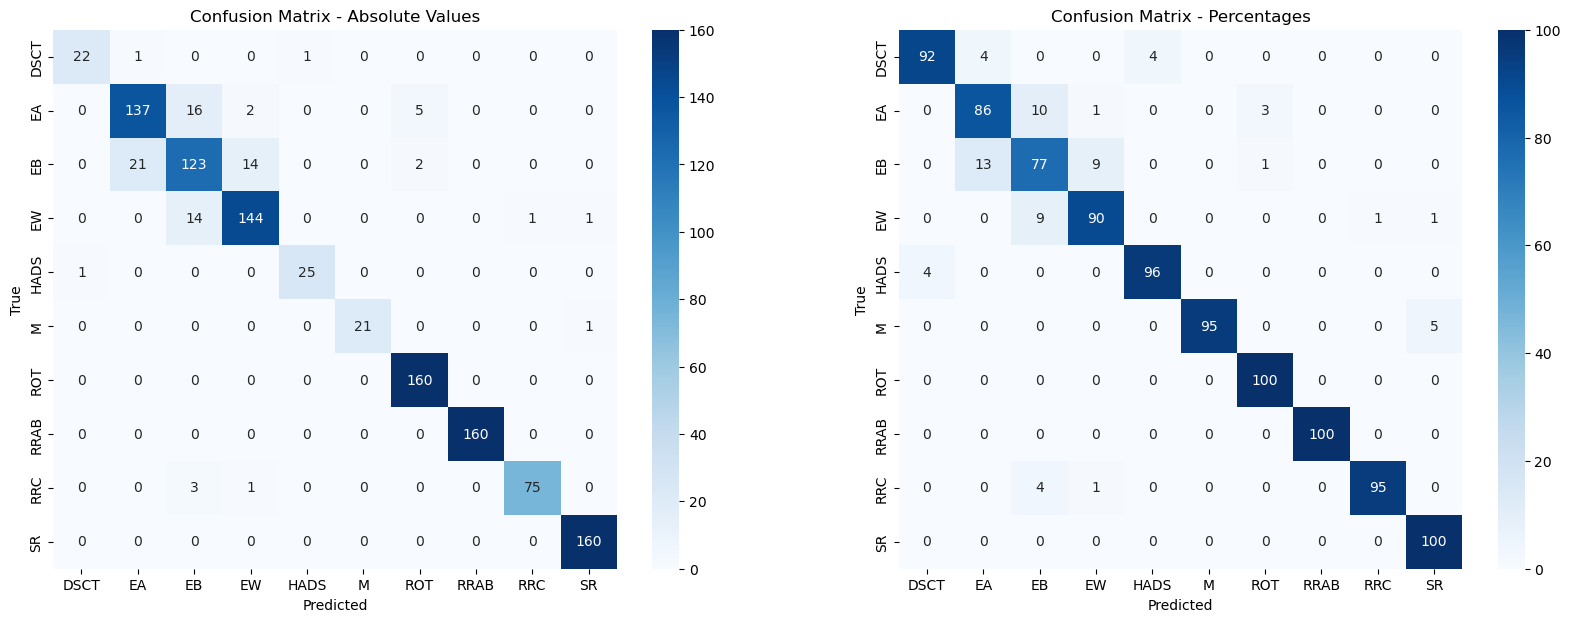

In [44]:
plot_matrices(avg, avg_percent)

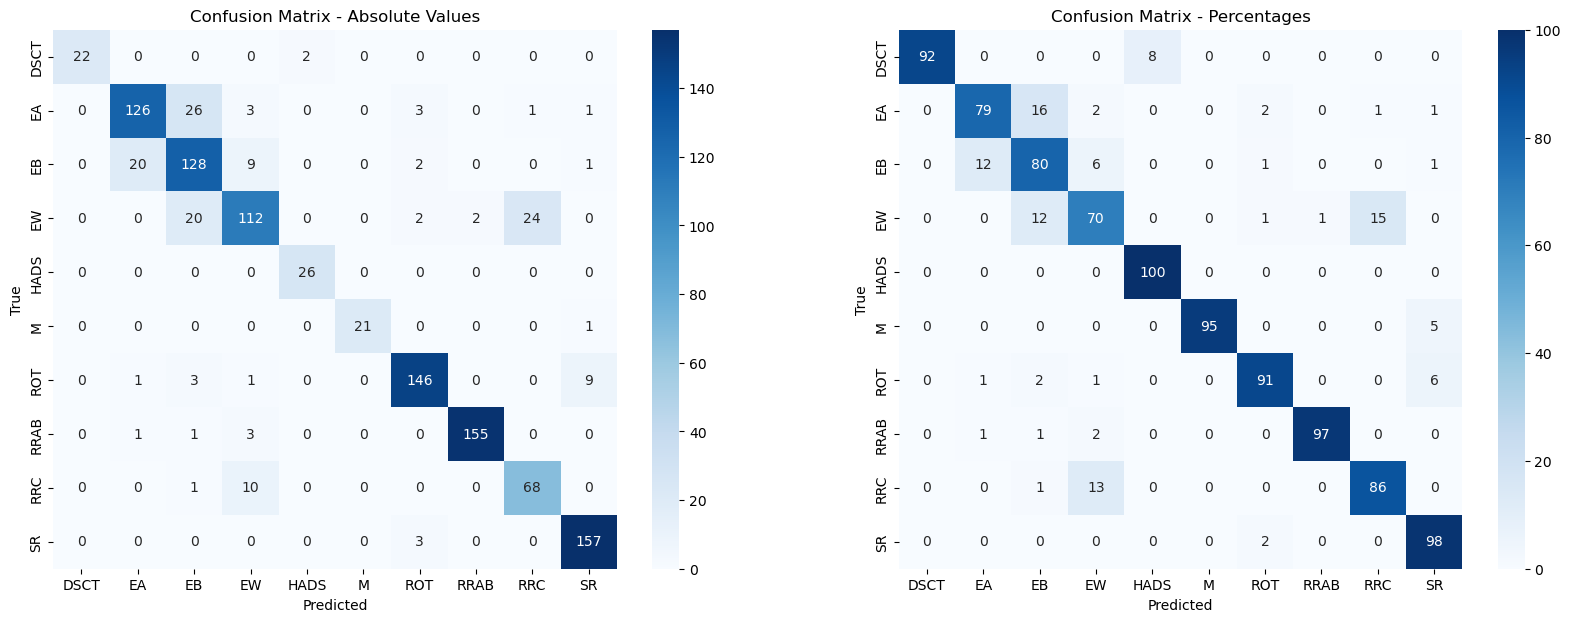

In [45]:
plot_matrices(p, p_percent)

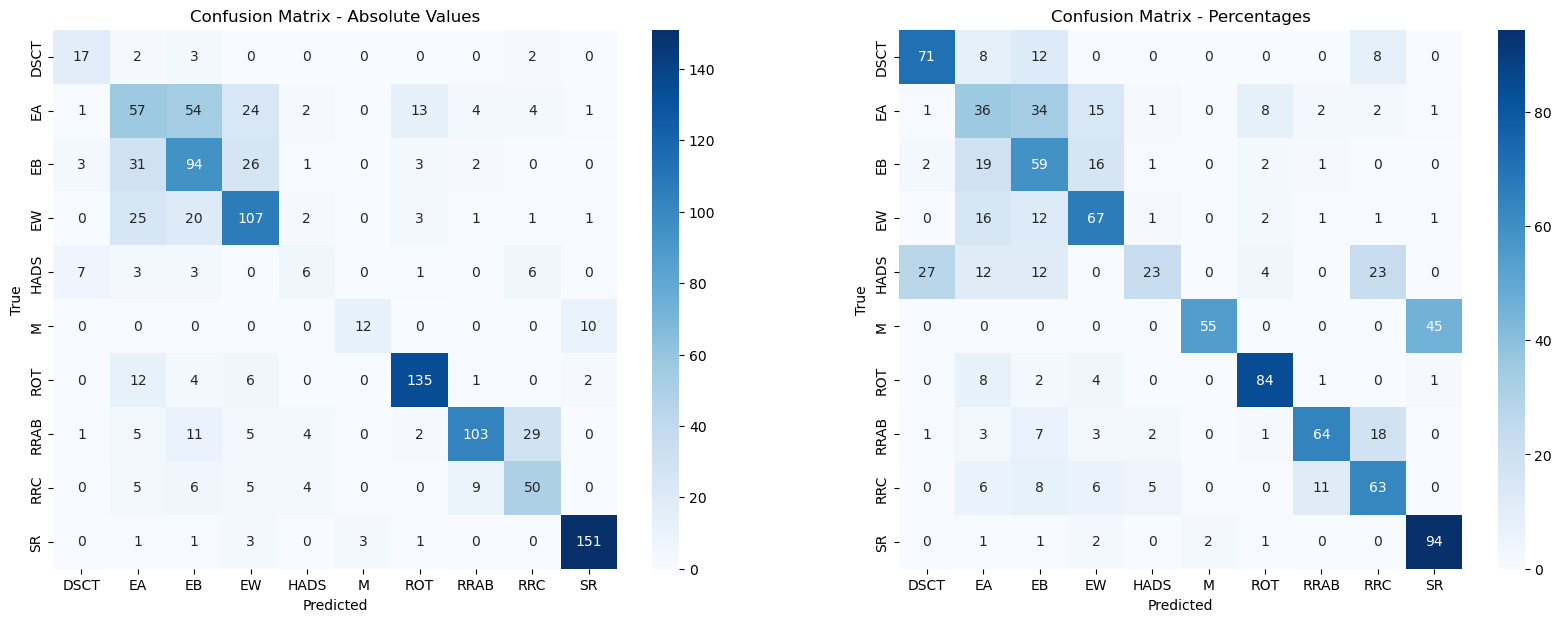

In [46]:
plot_matrices(s, s_percent)

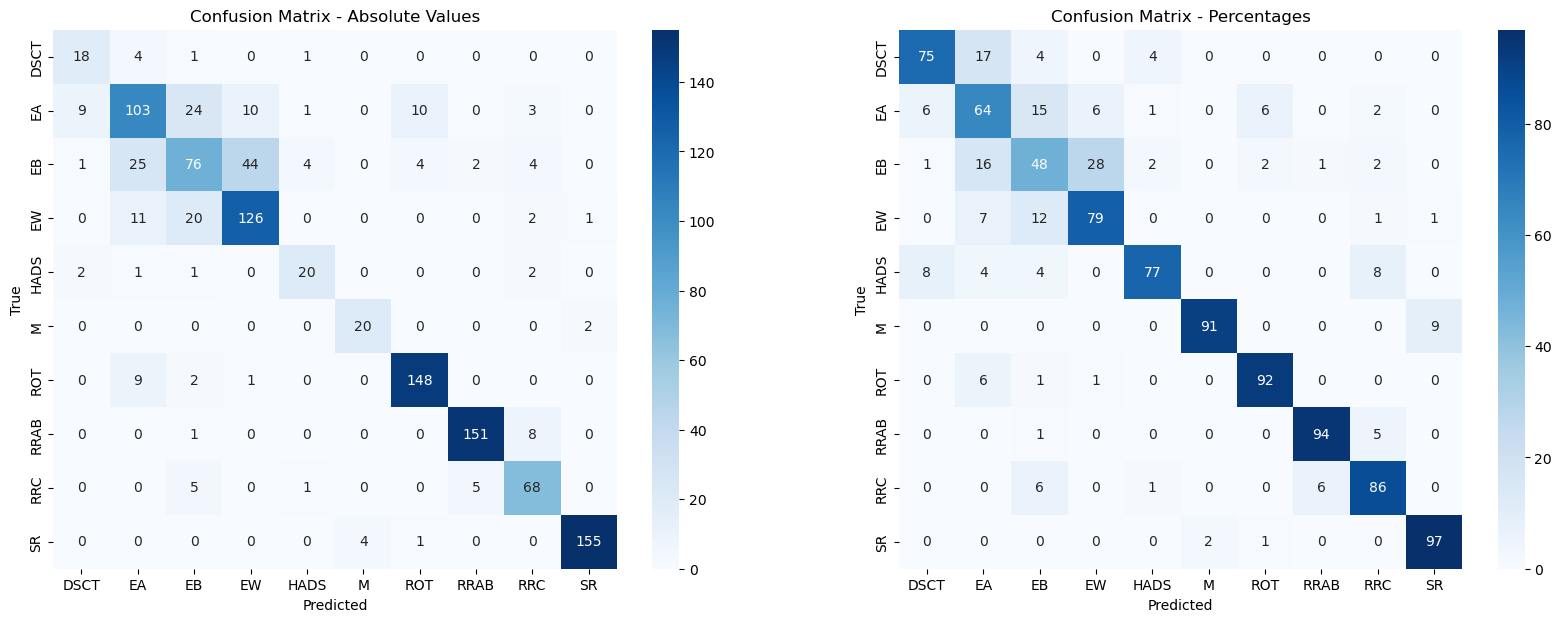

In [47]:
plot_matrices(m, m_percent)

In [48]:
classes = [test_dataset.id2target[i] for i in range(10)]
modalities = ["Photometry", "Spectra", "Metadata", "Combined"]
accuracy_data = {classes[i]: [p_percent[i][i], s_percent[i][i], m_percent[i][i], avg_percent[i][i]] for i in range(10)}

In [49]:
print(f'Class \t Photo \t Spectra \t Meta \t Avg')

for k, v in accuracy_data.items():
    print(f'{k} \t {round(v[0], 2)} \t {round(v[1], 2)} \t\t {round(v[2], 2)} \t {round(v[3], 2)}')

Class 	 Photo 	 Spectra 	 Meta 	 Avg
DSCT 	 91.67 	 70.83 		 75.0 	 91.67
EA 	 78.75 	 35.62 		 64.38 	 85.62
EB 	 80.0 	 58.75 		 47.5 	 76.88
EW 	 70.0 	 66.88 		 78.75 	 90.0
HADS 	 100.0 	 23.08 		 76.92 	 96.15
M 	 95.45 	 54.55 		 90.91 	 95.45
ROT 	 91.25 	 84.38 		 92.5 	 100.0
RRAB 	 96.88 	 64.38 		 94.38 	 100.0
RRC 	 86.08 	 63.29 		 86.08 	 94.94
SR 	 98.12 	 94.38 		 96.88 	 100.0


In [50]:
ps_emb = (test_p_emb + test_s_emb) / 2
ps_logits = model.fc(ps_emb.to(device))
ps_prob = torch.nn.functional.softmax(ps_logits, dim=1)
_, ps_pred = torch.max(ps_prob, dim=1)

sm_emb = (test_s_emb + test_m_emb) / 2
sm_logits = model.fc(sm_emb.to(device))
sm_prob = torch.nn.functional.softmax(sm_logits, dim=1)
_, sm_pred = torch.max(sm_prob, dim=1)

mp_emb = (test_m_emb + test_p_emb) / 2
mp_logits = model.fc(mp_emb.to(device))
mp_prob = torch.nn.functional.softmax(mp_logits, dim=1)
_, mp_pred = torch.max(mp_prob, dim=1)

In [51]:
ps = confusion_matrix(test_labels, ps_pred.cpu())
sm = confusion_matrix(test_labels, sm_pred.cpu())
mp = confusion_matrix(test_labels, mp_pred.cpu())

ps_percent = 100 * ps / ps.sum(axis=1)[:, np.newaxis]
sm_percent = 100 * sm / sm.sum(axis=1)[:, np.newaxis]
mp_percent = 100 * mp / mp.sum(axis=1)[:, np.newaxis]

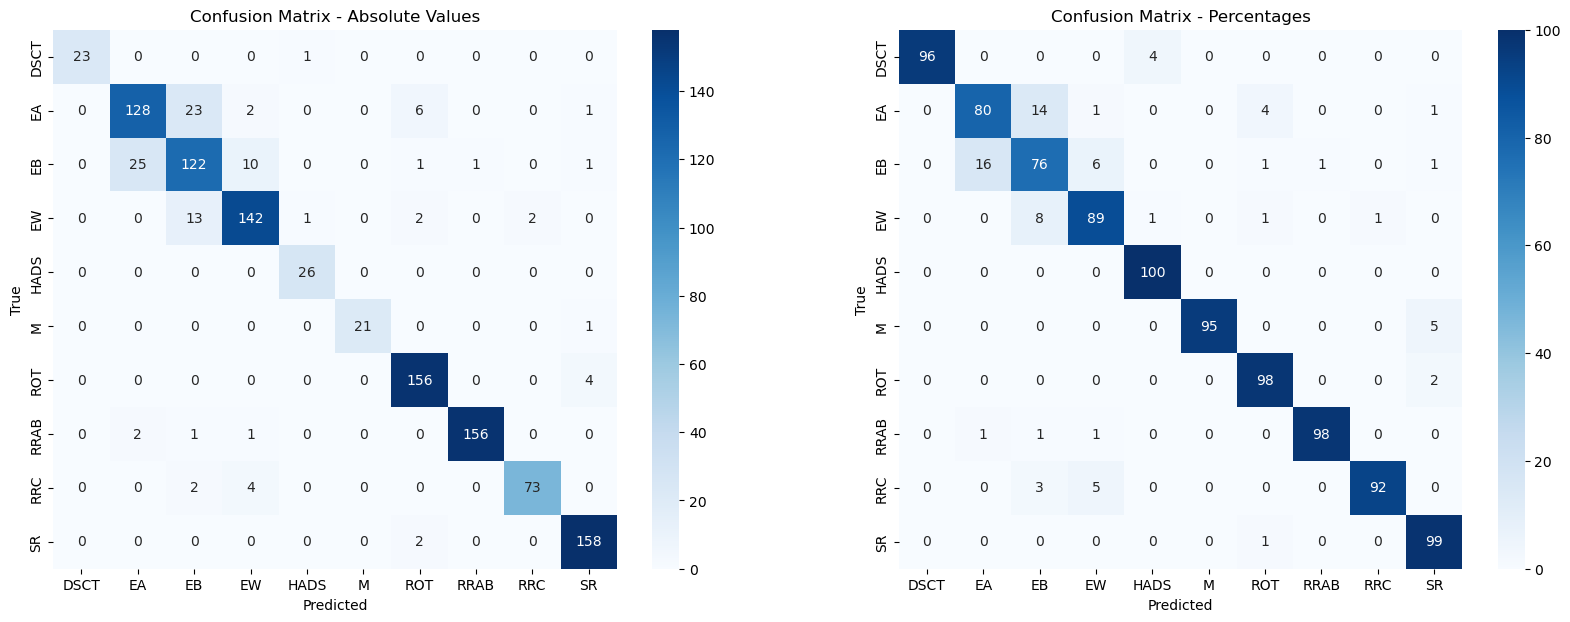

In [52]:
plot_matrices(ps, ps_percent)

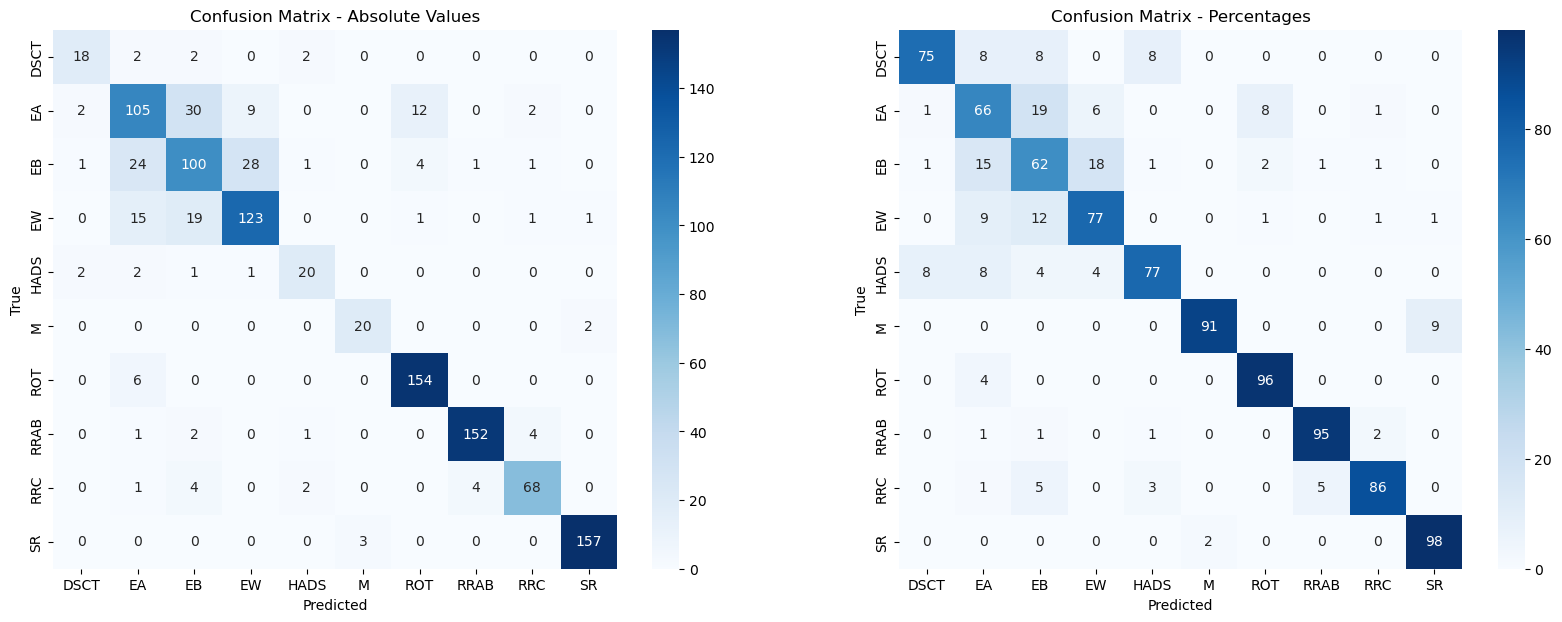

In [53]:
plot_matrices(sm, sm_percent)

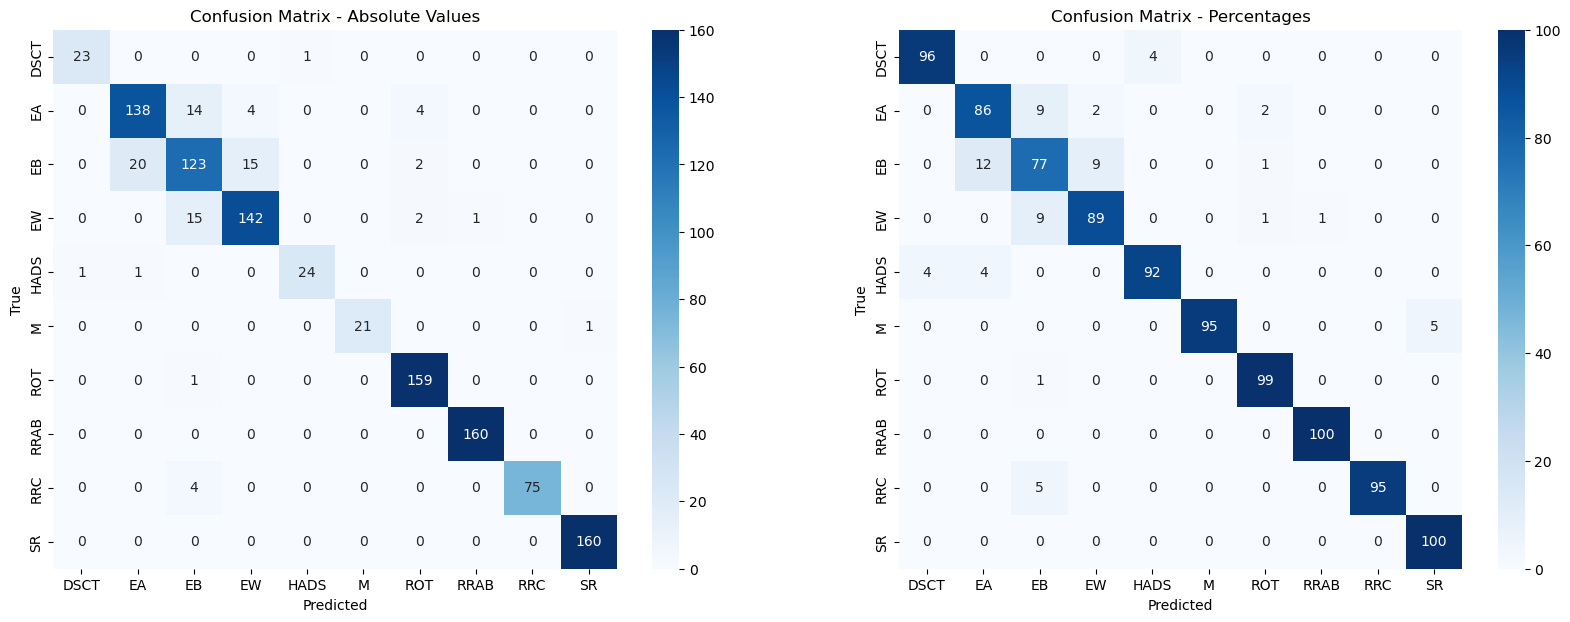

In [54]:
plot_matrices(mp, mp_percent)

In [55]:
# Column headers
print(f'{"Class":<15} {"Photo":^10} {"Spectra":^10} {"Meta":^10} {"Photo + Spectra":^15} {"Spectra + Meta":^15} {"Meta + Photo":^15} {"All":^10}')

# Data rows
for i in range(10):    
    print(f'{test_dataset.id2target[i]:<15} {round(p_percent[i][i], 2):^10} {round(s_percent[i][i], 2):^10} {round(m_percent[i][i], 2):^10} '
          f'{round(ps_percent[i][i], 2):^15} {round(sm_percent[i][i], 2):^15} {round(mp_percent[i][i], 2):^15} {round(avg_percent[i][i], 2):^10}')

Class             Photo     Spectra      Meta    Photo + Spectra Spectra + Meta   Meta + Photo      All    
DSCT              91.67      70.83       75.0         95.83           75.0            95.83        91.67   
EA                78.75      35.62      64.38         80.0            65.62           86.25        85.62   
EB                 80.0      58.75       47.5         76.25           62.5            76.88        76.88   
EW                 70.0      66.88      78.75         88.75           76.88           88.75         90.0   
HADS              100.0      23.08      76.92         100.0           76.92           92.31        96.15   
M                 95.45      54.55      90.91         95.45           90.91           95.45        95.45   
ROT               91.25      84.38       92.5         97.5            96.25           99.38        100.0   
RRAB              96.88      64.38      94.38         97.5            95.0            100.0        100.0   
RRC               86.08     

In [58]:
for i in range(10):    
    print(f'{test_dataset.id2target[i]} & {round(p_percent[i][i], 2)} & {round(s_percent[i][i], 2)} & {round(m_percent[i][i], 2)} & '
          f'{round(ps_percent[i][i], 2)} & {round(sm_percent[i][i], 2)} & {round(mp_percent[i][i], 2)} & {round(avg_percent[i][i], 2)}\\\\')

DSCT & 91.67 & 70.83 & 75.0 & 95.83 & 75.0 & 95.83 & 91.67\\
EA & 78.75 & 35.62 & 64.38 & 80.0 & 65.62 & 86.25 & 85.62\\
EB & 80.0 & 58.75 & 47.5 & 76.25 & 62.5 & 76.88 & 76.88\\
EW & 70.0 & 66.88 & 78.75 & 88.75 & 76.88 & 88.75 & 90.0\\
HADS & 100.0 & 23.08 & 76.92 & 100.0 & 76.92 & 92.31 & 96.15\\
M & 95.45 & 54.55 & 90.91 & 95.45 & 90.91 & 95.45 & 95.45\\
ROT & 91.25 & 84.38 & 92.5 & 97.5 & 96.25 & 99.38 & 100.0\\
RRAB & 96.88 & 64.38 & 94.38 & 97.5 & 95.0 & 100.0 & 100.0\\
RRC & 86.08 & 63.29 & 86.08 & 92.41 & 86.08 & 94.94 & 94.94\\
SR & 98.12 & 94.38 & 96.88 & 98.75 & 98.12 & 100.0 & 100.0\\


In [59]:
np.trace(p_percent) / 10

88.81971614883007

In [60]:
np.trace(s_percent) / 10

61.612185019621734

In [61]:
np.trace(m_percent) / 10

80.32831171992565

In [62]:
np.trace(ps_percent) / 10

92.24429420790179

In [63]:
np.trace(sm_percent) / 10

82.32831171992565

In [64]:
np.trace(mp_percent) / 10

92.97822799563306

In [65]:
np.trace(avg_percent) / 10

93.07117671358178

In [224]:
87.34 - 79.75

7.590000000000003

In [225]:
test_dataset.meta_cols

['mean_vmag',
 'phot_g_mean_mag',
 'e_phot_g_mean_mag',
 'phot_bp_mean_mag',
 'e_phot_bp_mean_mag',
 'phot_rp_mean_mag',
 'e_phot_rp_mean_mag',
 'bp_rp',
 'parallax',
 'parallax_error',
 'parallax_over_error',
 'pmra',
 'pmra_error',
 'pmdec',
 'pmdec_error',
 'j_mag',
 'e_j_mag',
 'h_mag',
 'e_h_mag',
 'k_mag',
 'e_k_mag',
 'w1_mag',
 'e_w1_mag',
 'w2_mag',
 'e_w2_mag',
 'w3_mag',
 'w4_mag',
 'j_k',
 'w1_w2',
 'w3_w4',
 'pm',
 'ruwe',
 'l',
 'b']